In [19]:
import pandas as pd
import numpy as np

updated_vegetation_data = pd.read_csv("data/vegetation_data.csv")

used_columns = ['Location','Year', 'MM_CA', 'MM_CEC', 'MM_K', 'MM_MG', 'MM_OM',
       'MM_P1', 'MM_PH', 'MM_CLAY', 'MM_SAND', 'MM_SILT', 'Plot', 'Yield', 'X', 'Population', 'Cl', 'Clre', 'Datt1',
       'Datt4', 'Datt6', 'DDI', 'DPI', 'GNDVI', 'MCARI', 'MCARI3', 'mSR',
       'mSR2', 'MTCI', 'MTVI1', 'ND1', 'ND2', 'NDchl', 'NDRE', 'NDVI1',
       'NDVI2', 'NDVI3', 'NPCL', 'NPQI', 'OSAVI', 'PBI', 'PPR', 'PRI',
       'PSNDb1', 'PSNDc1', 'PSNDc2', 'PSRI', 'PSSRc1', 'PSSRc2', 'PVR', 'PWI',
       'RDVI', 'RVSI', 'SAVI', 'SIPI', 'SR1', 'SR2', 'SR3', 'SR4', 'DSWI-4',
       'SRPI', 'TCARI', 'TCI', 'TVI', 'WBI', 'Latitude', 'Longitude']

updated_vegetation_data = updated_vegetation_data[used_columns]


In [20]:
updated_vegetation_data.columns

Index(['Location', 'Year', 'MM_CA', 'MM_CEC', 'MM_K', 'MM_MG', 'MM_OM',
       'MM_P1', 'MM_PH', 'MM_CLAY', 'MM_SAND', 'MM_SILT', 'Plot', 'Yield', 'X',
       'Population', 'Cl', 'Clre', 'Datt1', 'Datt4', 'Datt6', 'DDI', 'DPI',
       'GNDVI', 'MCARI', 'MCARI3', 'mSR', 'mSR2', 'MTCI', 'MTVI1', 'ND1',
       'ND2', 'NDchl', 'NDRE', 'NDVI1', 'NDVI2', 'NDVI3', 'NPCL', 'NPQI',
       'OSAVI', 'PBI', 'PPR', 'PRI', 'PSNDb1', 'PSNDc1', 'PSNDc2', 'PSRI',
       'PSSRc1', 'PSSRc2', 'PVR', 'PWI', 'RDVI', 'RVSI', 'SAVI', 'SIPI', 'SR1',
       'SR2', 'SR3', 'SR4', 'DSWI-4', 'SRPI', 'TCARI', 'TCI', 'TVI', 'WBI',
       'Latitude', 'Longitude'],
      dtype='object')

In [27]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance_matrix

# Compute pairwise distances based on latitude and longitude
distances = distance_matrix(updated_vegetation_data[['Latitude', 'Longitude']].values, 
                            updated_vegetation_data[['Latitude', 'Longitude']].values)

# Set a threshold based on the 5th percentile of distances (excluding zero)
threshold = np.percentile(distances[distances > 0], 5)

# Create edges based on the threshold
spatial_edges = np.argwhere(distances < threshold)

# Remove self-loops (i.e., where source and target nodes are the same)
spatial_edges = spatial_edges[spatial_edges[:, 0] != spatial_edges[:, 1]]

spatial_edges[:10], len(spatial_edges)  # Displaying first 10 edges and total number of spatial edges


(array([[  0,   1],
        [  0,  69],
        [  0, 116],
        [  0, 132],
        [  0, 172],
        [  0, 177],
        [  0, 184],
        [  0, 204],
        [  0, 225],
        [  0, 235]], dtype=int64),
 585676)

In [28]:
# Function to generate genotype-based edges
def create_genotype_edges(data, column, num_samples):
    """
    Generate edges based on a specific column (e.g., genotype or population).
    
    Args:
    - data (DataFrame): The dataset containing the column.
    - column (str): Name of the column to base the edges on.
    - num_samples (int): Number of edges to sample for each unique value in the column.
    
    Returns:
    - np.array: Array of edges.
    """
    edges = []
    
    # Extract unique values from the specified column
    unique_values = data[column].unique()
    
    for value in unique_values:
        # Extract nodes associated with the current unique value
        nodes = data[data[column] == value].index.values
        
        # Randomly sample edges among these nodes
        sampled_edges = sample_genotype_edges(nodes, num_samples)
        
        # Append the sampled edges to the list
        edges.extend(sampled_edges)
    
    return np.array(edges)

# Generate genotype-based edges using the Population column
num_samples_per_population = 100  # Number of edges to sample for each population
genotype_edges = create_genotype_edges(updated_vegetation_data, 'Population', num_samples_per_population)

genotype_edges[:10], len(genotype_edges)  # Displaying first 10 edges and total number of genotype edges


(array([[1160, 2835],
        [2928, 1644],
        [ 674, 3298],
        [2784,    0],
        [3290, 1644],
        [  25, 3157],
        [3116,  907],
        [  99, 3116],
        [2395,  391],
        [3333,  907]], dtype=int64),
 7900)

In [29]:
import torch
from torch_geometric.data import Data

# 1. Constructing the Graph

# Combine the spatial and genotype edges to get all edges for the graph
all_edges = np.vstack([spatial_edges, genotype_edges])

# Convert the edges to a tensor format suitable for PyTorch Geometric
edge_index = torch.tensor(all_edges, dtype=torch.long).t().contiguous()

# Extract node features. We are excluding non-numerical columns and columns that are not relevant for the features.
# This ensures that only the vegetation indices and other numerical columns (like time) are used as features.
numerical_cols = updated_vegetation_data.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['Latitude', 'Longitude', 'Population', 'Location']
feature_cols = [col for col in numerical_cols if col not in exclude_cols]
node_features = updated_vegetation_data[feature_cols].values
x = torch.tensor(node_features, dtype=torch.float)

# Extract the target label, which is the 'Harvest_Yield' column
# Extract the target label, which is the 'Yield' column
y = torch.tensor(updated_vegetation_data['Yield'].values, dtype=torch.float).unsqueeze(1)

# Create a PyTorch Geometric Data object. This object will be the graph representation used for training the GNN.
data = Data(x=x, edge_index=edge_index, y=y)

# 2. Setting Up the GraphSAGE Model (This will be done after ensuring the graph is correctly constructed)

# ... Model code will follow here ...



In [35]:
from torch import nn
class EnhancedGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EnhancedGraphSAGE, self).__init__()
        
        # Initial GraphSAGE layer
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        
        # Additional GraphSAGE layers
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        
        # Final GraphSAGE layer for prediction
        self.conv4 = SAGEConv(hidden_channels, out_channels)
        
        # Batch normalization layers for the hidden layers
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index):
        # Initial layer
        x0 = F.relu(self.conv1(x, edge_index))
        x0 = self.bn1(x0)
        x0 = F.dropout(x0, p=0.5, training=self.training)
        
        # Second layer with skip connection
        x1 = F.relu(self.conv2(x0, edge_index) + x0)
        x1 = self.bn2(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)
        
        # Third layer with skip connection
        x2 = F.relu(self.conv3(x1, edge_index) + x1)
        x2 = self.bn3(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        
        # Final layer to produce output
        out = self.conv4(x2, edge_index)
        
        return out

# Define the dimensions
in_channels = data.x.size(1)  # Number of input features (node features)
hidden_channels = 64  # Size of the hidden layer
out_channels = 1  # We're performing regression, so we have one output

# Instantiate the enhanced model
model = EnhancedGraphSAGE(in_channels, hidden_channels, out_channels)


In [36]:
# 1. Model Architecture Explanation:
# The Enhanced GraphSAGE model is designed to capture both local and broader neighborhood information of nodes for prediction tasks.

# SAGEConv Layers: These are the primary layers in our GraphSAGE model. They operate by aggregating information from neighboring nodes, transforming this aggregated data, and then combining it with the node's own features.

# Batch Normalization: After each SAGEConv layer, we apply batch normalization. This helps in stabilizing and accelerating the training of deep networks. It normalizes the output of each layer to have a mean of zero and a variance of one.

# ReLU Activation: After normalization, we apply the Rectified Linear Unit (ReLU) activation function. It introduces non-linearity to the model, allowing it to capture complex patterns.

# Dropout: It's a regularization technique where randomly selected neurons are ignored during training. This helps in preventing overfitting.

# Skip Connections: These are shortcuts that bypass one or more layers. They help in combating the vanishing gradient problem in deeper networks and enhance the flow of information.

# In the architecture:

# The first layer captures immediate neighborhood information.
# Subsequent layers capture broader neighborhood information, with each layer effectively doubling the "reach" of neighborhood information considered.
# Skip connections help in retaining the information from previous layers, allowing the model to use both shallow and deep node representations.


Epoch 1/10, Train Loss: 76.82657623291016, Validation Loss: 419.2535095214844
Epoch 2/10, Train Loss: 111.86125183105469, Validation Loss: 465.0143127441406
Epoch 3/10, Train Loss: 61.088932037353516, Validation Loss: 3188.677001953125
Epoch 4/10, Train Loss: 64.13883972167969, Validation Loss: 1061.934326171875
Epoch 5/10, Train Loss: 73.35584259033203, Validation Loss: 46.399497985839844
Epoch 6/10, Train Loss: 58.682701110839844, Validation Loss: 59.750152587890625
Epoch 7/10, Train Loss: 45.38665771484375, Validation Loss: 86.17757415771484
Epoch 8/10, Train Loss: 50.04352569580078, Validation Loss: 132.70611572265625
Epoch 9/10, Train Loss: 59.8920783996582, Validation Loss: 155.69264221191406
Epoch 10/10, Train Loss: 53.185733795166016, Validation Loss: 147.29335021972656
Test Loss: 153.82669067382812


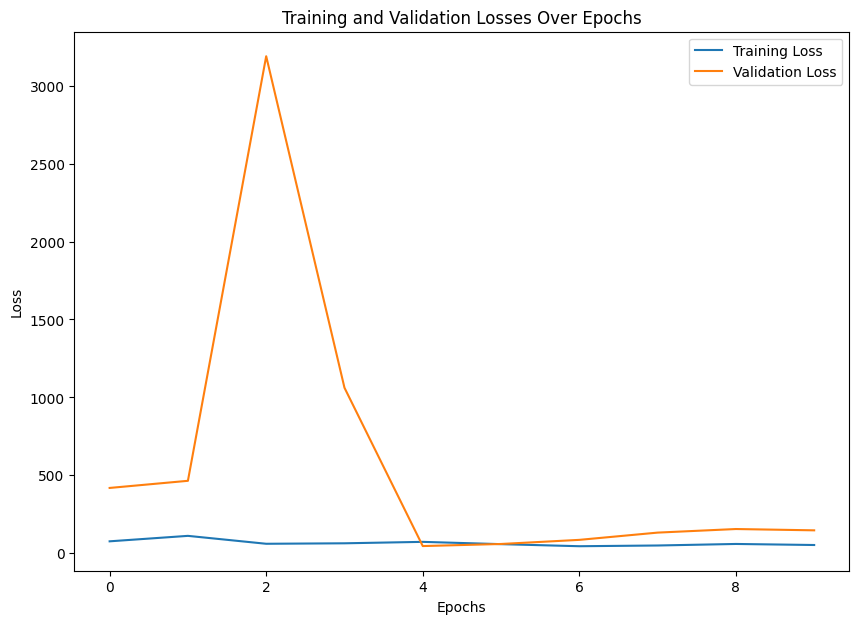

In [46]:
from torch.utils.data import random_split
from torch.optim import Adam
from torch.nn import MSELoss
import matplotlib.pyplot as plt

# Calculate the number of nodes (samples) in our dataset
num_nodes = len(data.y)

# Define the lengths for the train, validation, and test splits
train_length = int(0.7 * num_nodes)
val_length = int(0.2 * num_nodes)
test_length = num_nodes - train_length - val_length

# Create a mask for the nodes we'll use for training, validation, and testing
node_indices = torch.arange(num_nodes)
train_indices, val_indices, test_indices = random_split(node_indices, [train_length, val_length, test_length])

# Convert the output of random_split (Subset object) into boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices.indices] = True
val_mask[val_indices.indices] = True
test_mask[test_indices.indices] = True

# Attach the masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Define the loss criterion and optimizer
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation function
def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return loss.item()

# Testing function
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.test_mask], data.y[data.test_mask])
    return loss.item()

# Training and validation
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train()
    val_loss = validate()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

# Testing the model
test_loss = test()
print(f"Test Loss: {test_loss}")

# Plotting training and validation losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()


NameError: name 'all_edges' is not defined

In [48]:
from itertools import product

# Define hyperparameter search space
learning_rates = [0.001, 0.005, 0.01, .02]
hidden_channels_list = [32, 64, 128]
dropouts = [0.3, 0.5, 0.7]

# Placeholders for best parameters and best loss
best_params = {}
best_loss = float('inf')

# Grid search
for lr, hidden_channels, dropout in product(learning_rates, hidden_channels_list, dropouts):
    
    # Define the model with the current hyperparameters
    model = EnhancedGraphSAGE(in_channels, hidden_channels, out_channels)
    
    # Define the loss criterion and optimizer with current learning rate
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train the model for a smaller number of epochs (e.g., 3) for time efficiency during hyperparameter tuning
    for epoch in range(50):
        train_loss = train()
        val_loss = validate()
        
        # Print the epoch, training loss, and validation loss
        print(f"lr: {lr}, hidden_channels: {hidden_channels}, dropout: {dropout}, epoch: {epoch+1}/3, Train Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # Check if current validation loss is the best
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = {'learning_rate': lr, 'hidden_channels': hidden_channels, 'dropout': dropout}

print(f"Best parameters: {best_params} with validation loss: {best_loss}")


lr: 0.001, hidden_channels: 32, dropout: 0.3, epoch: 1/3, Train Loss: 4712.712890625, Validation Loss: 1870.7857666015625
lr: 0.001, hidden_channels: 32, dropout: 0.3, epoch: 2/3, Train Loss: 4710.2099609375, Validation Loss: 2874.990234375
lr: 0.001, hidden_channels: 32, dropout: 0.3, epoch: 3/3, Train Loss: 4712.33740234375, Validation Loss: 3363.61328125
lr: 0.001, hidden_channels: 32, dropout: 0.5, epoch: 1/3, Train Loss: 4730.0751953125, Validation Loss: 7393.552734375
lr: 0.001, hidden_channels: 32, dropout: 0.5, epoch: 2/3, Train Loss: 4732.2802734375, Validation Loss: 6288.39306640625
lr: 0.001, hidden_channels: 32, dropout: 0.5, epoch: 3/3, Train Loss: 4728.6357421875, Validation Loss: 5730.77490234375
lr: 0.001, hidden_channels: 32, dropout: 0.7, epoch: 1/3, Train Loss: 4717.1201171875, Validation Loss: 4156.69873046875
lr: 0.001, hidden_channels: 32, dropout: 0.7, epoch: 2/3, Train Loss: 4717.1416015625, Validation Loss: 4305.97412109375
lr: 0.001, hidden_channels: 32, dropo

KeyboardInterrupt: 

C:\Users\gupta\AppData\Local\Temp\ipykernel_55116\1981415617.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=3, color='red')  # Diagonal line


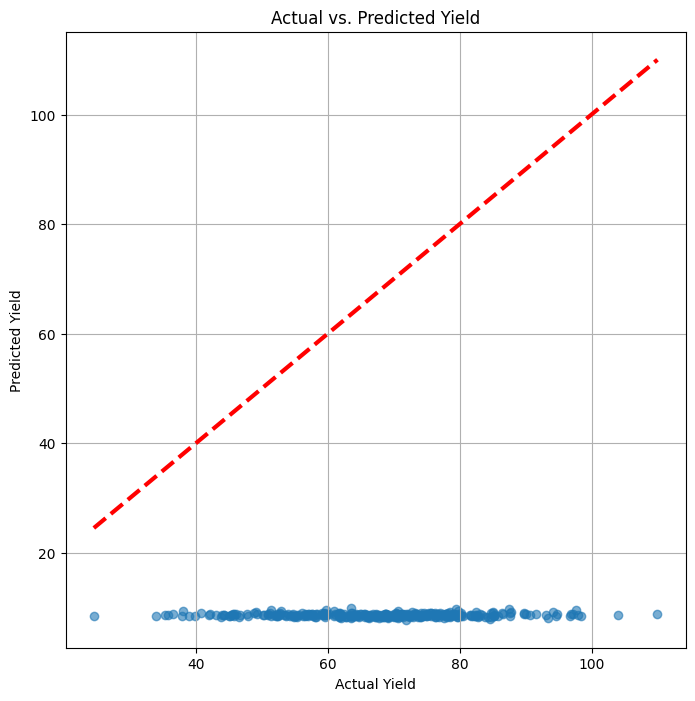

In [51]:
import matplotlib.pyplot as plt

# Get the predictions on the test set
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index)[data.test_mask].cpu().numpy()
    
# Get the actual values from the test set
actual = data.y[data.test_mask].cpu().numpy()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(actual, predictions, alpha=0.6)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=3, color='red')  # Diagonal line
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs. Predicted Yield')
plt.grid(True)
plt.show()


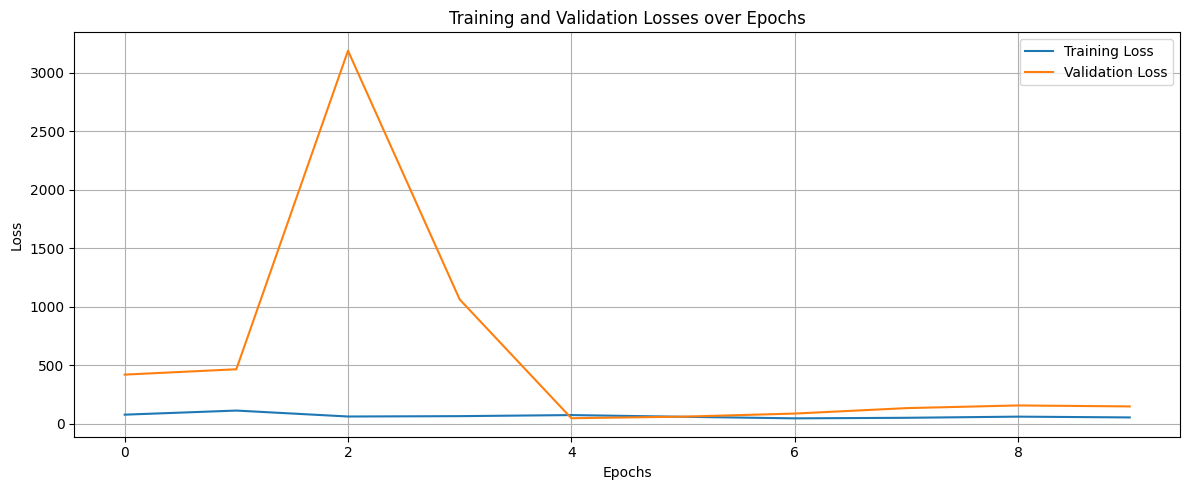

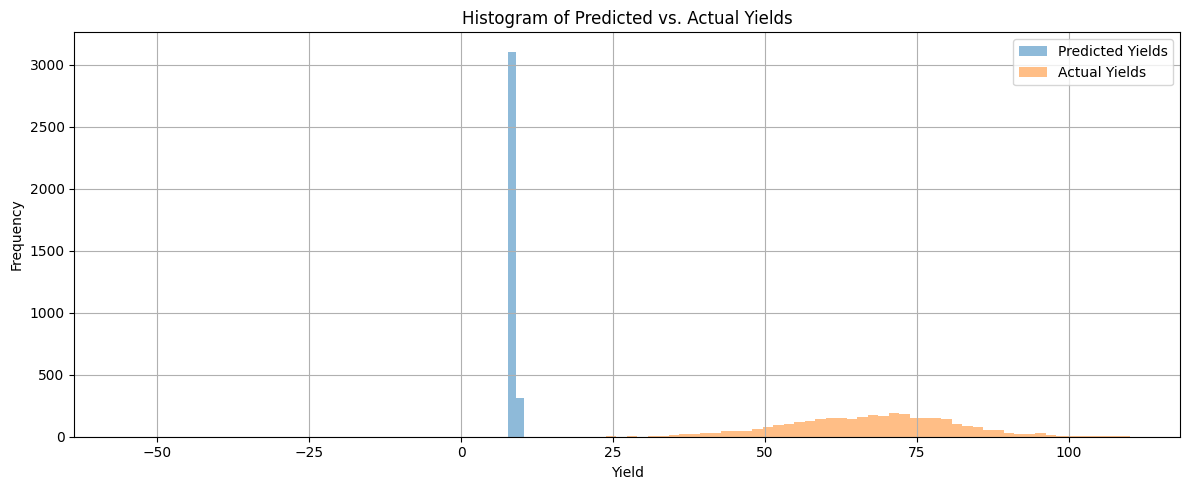

AttributeError: 'SAGEConv' object has no attribute 'weight'

In [52]:
import matplotlib.pyplot as plt

# 1. Loss Curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Histogram of Predictions
# First, get the predictions on the entire dataset
model.eval()
with torch.no_grad():
    all_predictions = model(data.x, data.edge_index).cpu().numpy()
    
actual_yields = data.y.cpu().numpy()

plt.figure(figsize=(12, 5))
plt.hist(all_predictions, bins=50, alpha=0.5, label='Predicted Yields')
plt.hist(actual_yields, bins=50, alpha=0.5, label='Actual Yields')
plt.title('Histogram of Predicted vs. Actual Yields')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Feature Importances (from the first layer weights)
# This is a simplistic way to view importance and should be interpreted with caution
feature_importances = model.conv1.weight.mean(dim=0).abs().cpu().detach().numpy()
features = updated_vegetation_data.columns[:-2]  # excluding Latitude and Longitude

plt.figure(figsize=(12, 8))
plt.barh(features, feature_importances, align='center')
plt.title('Feature Importances (based on first layer weights)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


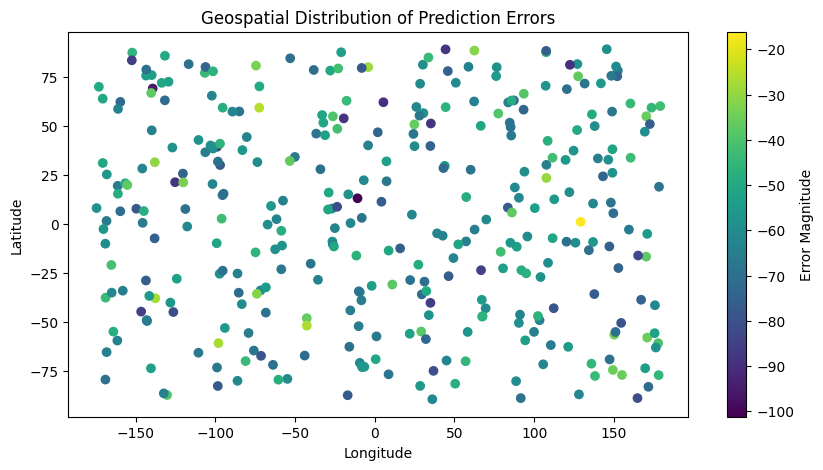

In [64]:
longitudes = updated_vegetation_data["Longitude"].values
latitudes = updated_vegetation_data["Latitude"].values

plt.figure(figsize=(10, 5))
plt.scatter(longitudes[data.test_mask.cpu().numpy()], latitudes[data.test_mask.cpu().numpy()], c=errors, cmap="viridis")
plt.colorbar(label='Error Magnitude')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Distribution of Prediction Errors")
plt.show()


In [68]:
def get_prediction(node_features, edge_index):
    model.eval() # Ensure the model is in evaluation mode
    with torch.no_grad():
        out = model(node_features, edge_index)
    return out

# For the sake of this example, let's consider a node at index 0
node_idx = 0

# Define an empty edge index (isolated node)
empty_edge_index = torch.empty((2, 0), dtype=torch.long)

# Define a full edge index (node connected to all other nodes)
connected_edges = [[node_idx]*len(node_features), list(range(len(node_features)))]
full_edge_index = torch.tensor(connected_edges, dtype=torch.long)

isolated_prediction = get_prediction(data.x, empty_edge_index)[node_idx]
connected_prediction = get_prediction(data.x, full_edge_index)[node_idx]

print(f"Prediction for node {node_idx} when isolated: {isolated_prediction.item()}")
print(f"Prediction for node {node_idx} when connected: {connected_prediction.item()}")


Prediction for node 0 when isolated: -27.626266479492188
Prediction for node 0 when connected: 5.619548797607422


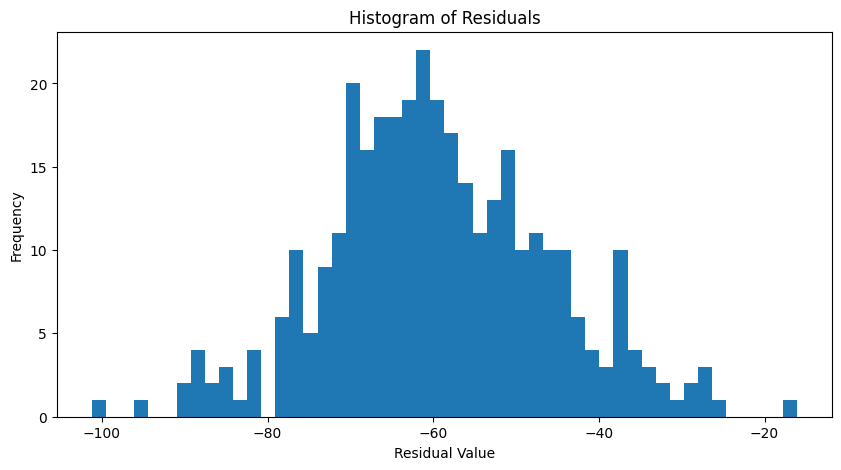

In [61]:
residuals = predictions.flatten() - actuals.flatten()

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


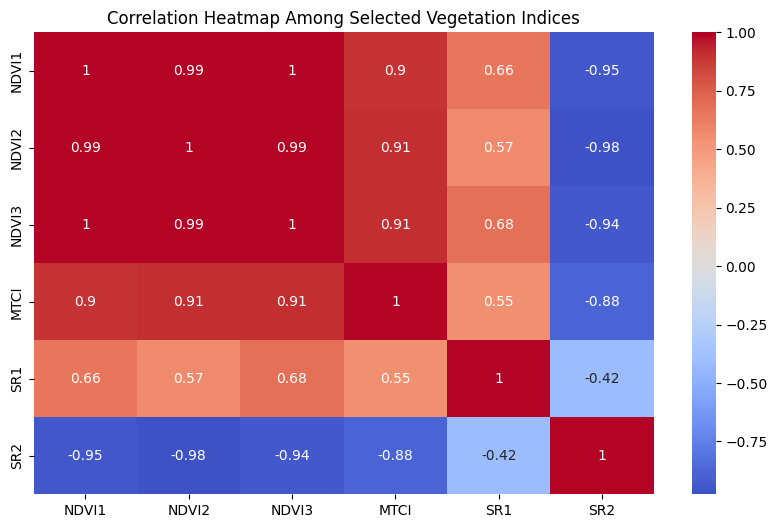

In [70]:
# Select a subset of vegetation indices
vi_features = ['NDVI1', 'NDVI2', 'NDVI3', 'MTCI', 'SR1', 'SR2']

correlations = updated_vegetation_data[vi_features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, cmap='coolwarm', annot=True, center=0)
plt.title("Correlation Heatmap Among Selected Vegetation Indices")
plt.show()


In [72]:
# # Replace with actual column names related to time
# time_features = ['feature1_time', 'feature2_time']

# correlations = updated_vegetation_data[time_features].corr()

# plt.figure(figsize=(8, 5))
# sns.heatmap(correlations, cmap='coolwarm', annot=True, center=0)
# plt.title("Correlation Heatmap Among Time-related Features")
# plt.show()
# # Correlation between spatial features (assuming some other spatial features are present)
# spatial_features = ['Latitude', 'Longitude', 'some_spatial_feature']

# correlations = updated_vegetation_data[spatial_features].corr()

# plt.figure(figsize=(8, 5))
# sns.heatmap(correlations, cmap='coolwarm', annot=True, center=0)
# plt.title("Correlation Heatmap Among Spatial Features")
# plt.show()


C:\Users\gupta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\gupta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


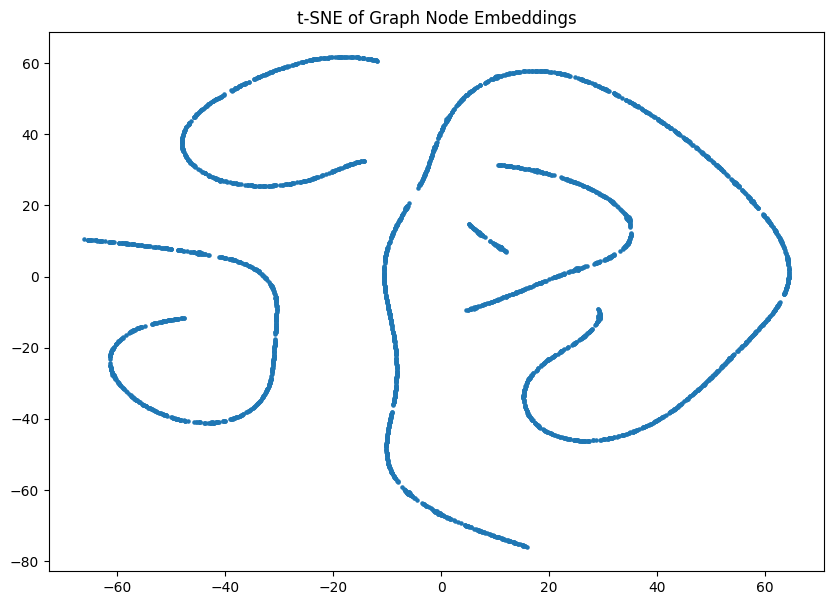

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get embeddings using the forward method of the model
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()

# Use t-SNE for dimensionality reduction
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=5)
plt.title('t-SNE of Graph Node Embeddings')
plt.show()


In [44]:
import folium

# Create a base map
m = folium.Map(location=[updated_vegetation_data['Latitude'].mean(), updated_vegetation_data['Longitude'].mean()], zoom_start=10)

# Add nodes to the map
for _, row in updated_vegetation_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        fill=True,
    ).add_to(m)

m


In [45]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [ ]:
import networkx as nx

G = nx.from_edgelist(data.edge_index.t().numpy())
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_size=500, node_color="skyblue")
plt.title('Graph Structure')
plt.show()
